In [1]:
# imports libraries
import re

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD


import nltk
from nltk.stem import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy 

import matplotlib.pyplot as plt

from unidecode import unidecode
import unicodedata as ud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import optuna

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import ConfusionMatrixDisplay

# This is used to turn on/off the optuna optimization cells
optimization = False

In [2]:
TestSet = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/test_set.csv")
ValidationSet = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/valid_set.csv")
TrainSet = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/train_set.csv")
SampleSubmission = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/sample_submission.csv")

In [3]:
# Drop useless columns
Xtrain = TrainSet.drop(['Sentiment', 'New_ID','Party'], axis=1)
Xval = ValidationSet.drop(['Sentiment', 'New_ID','Party'], axis=1)
Xtest = TestSet.drop(['New_ID','Party'], axis=1)

# create target
Ytrain = TrainSet[['Sentiment']].copy() 
Yval = ValidationSet[['Sentiment']].copy()

# Merge train and validation sets (It will be useful for the cross validation)
Xmerged = pd.concat([Xtrain, Xval])
Ymerged = pd.concat([Ytrain, Yval])

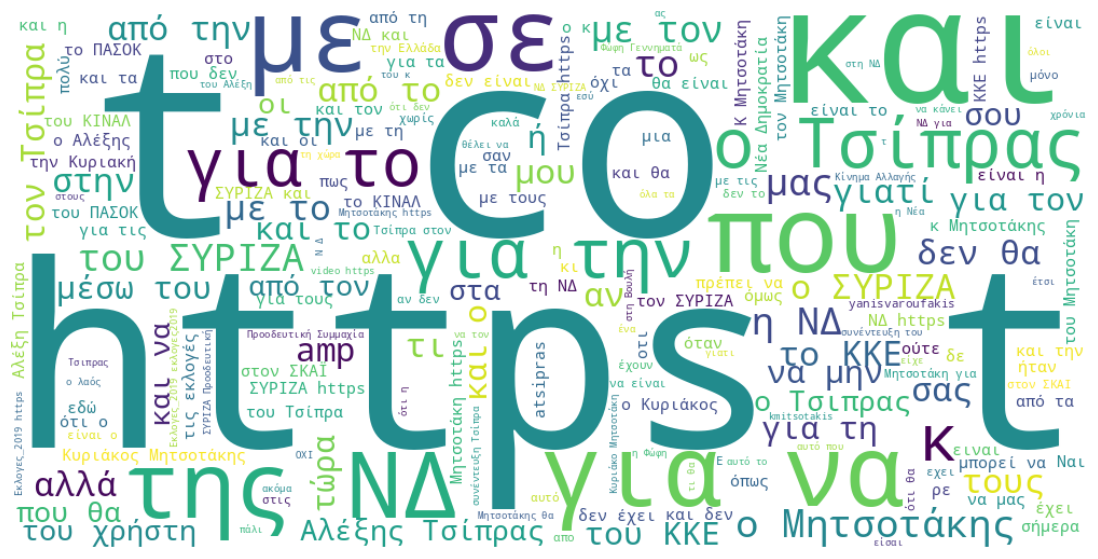

In [4]:
# Concatenate the text data from the column 'Text'
column_data = ' '.join(Xtrain['Text'])

# Create a wordcloud object before cleaning 
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(column_data)

# Plot the wordcloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


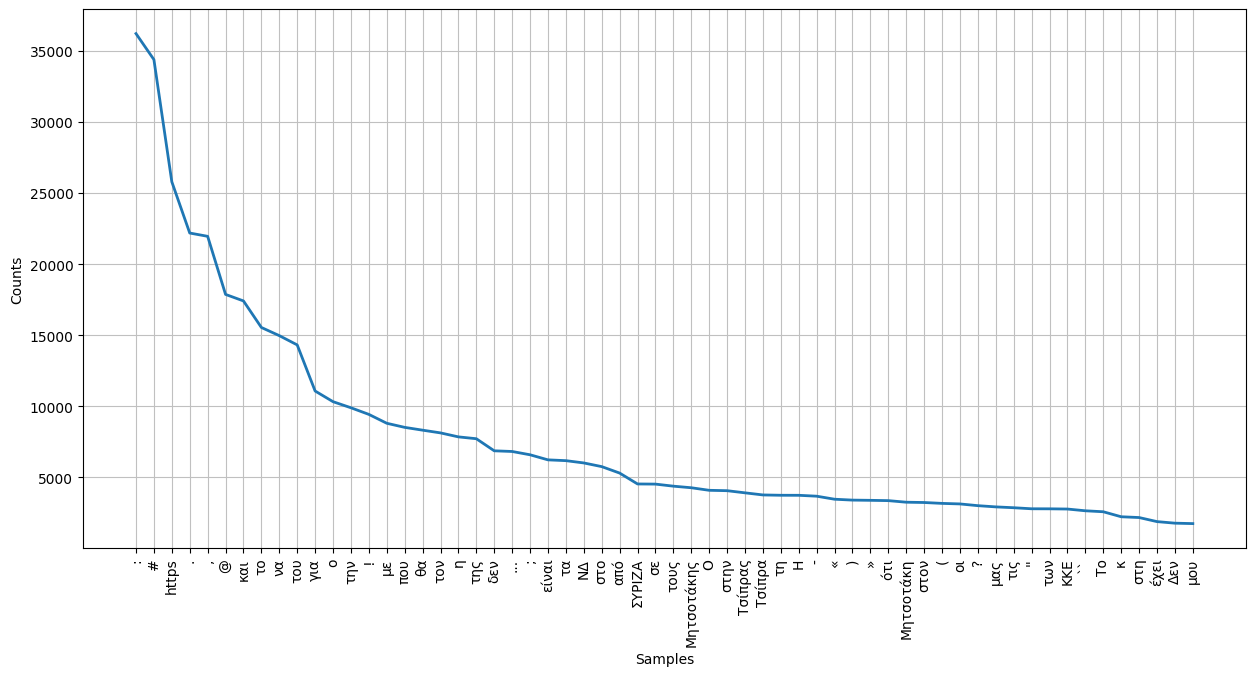

In [5]:
# Create a tokens frequency diagram before cleaning

nltk.download('punkt')
tokens = [word_tokenize(word, language='greek') for word in Xtrain['Text']]
token_frequency = FreqDist(np.hstack(tokens))
plt.figure(figsize=(15,7))
token_frequency.plot(60, cumulative=False)

In [6]:
# ROC Curve function
def Roc_curve_plot(x_val_pred,y_train_roc_curve,y_val_roc_curve):

    label_binarizer = LabelBinarizer().fit(y_train_roc_curve)
    y_onehot_test = label_binarizer.transform(y_val_roc_curve)


    #Plot Positive ROC Curve 
    class_of_interest_Positive = "POSITIVE"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest_Positive)[0]
    
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        x_val_pred[:, class_id],
        name="Positive vs(Negative and Neutral)",
        color="blue",
    )
    
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    
    #Plot Negative ROC Curve
    class_of_interest_Negative = "NEGATIVE"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest_Negative)[0]
    
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        x_val_pred[:, class_id],
        name="Negative vs(Positive and Neutral)",
        color="blue",
    )
    plt.axis("square")
    plt.xlabel("False Negative Rate")
    plt.ylabel("True Negative Rate")
    plt.legend()
    plt.show()
    

    # Plot Neutral ROC Curve
    class_of_interest_Neutral = "NEUTRAL"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest_Neutral)[0]
    
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        x_val_pred[:, class_id],
        name="Neutral vs(Positive and Negative)",
        color="blue",
    )
    plt.axis("square")
    plt.xlabel("False Neutral Rate")
    plt.ylabel("True Neutral Rate")
    plt.legend()
    plt.show()

F1 Score Train: 1.0
F1 Score Validation: 0.25728204011266104
F1 Score Train: 0.998918617193531
F1 Score Validation: 0.3705416102116173
F1 Score Train: 0.9956536058327294
F1 Score Validation: 0.36182352070267215
F1 Score Train: 0.9930161921928184
F1 Score Validation: 0.3775108111020826
F1 Score Train: 0.9899919111964705
F1 Score Validation: 0.37622653173311843
F1 Score Train: 0.9874117857435766
F1 Score Validation: 0.37803316264250203
F1 Score Train: 0.9855091248056655
F1 Score Validation: 0.3820820988849276
F1 Score Train: 0.9818516194923501
F1 Score Validation: 0.37774421828635146
F1 Score Train: 0.9806065526755398
F1 Score Validation: 0.3838437045780784
F1 Score Train: 0.9769718613196706
F1 Score Validation: 0.38873116966590415


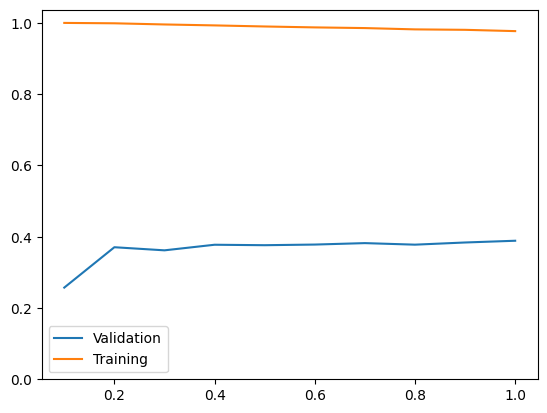

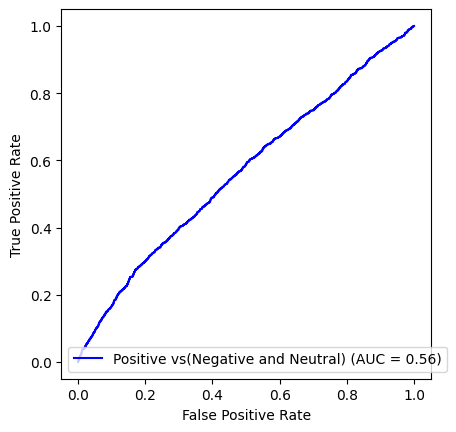

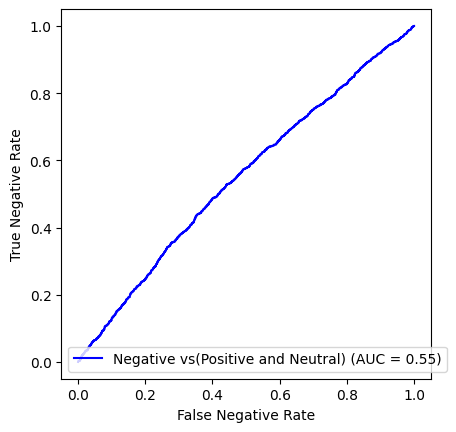

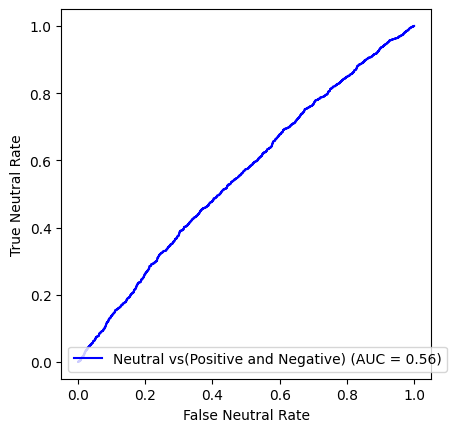

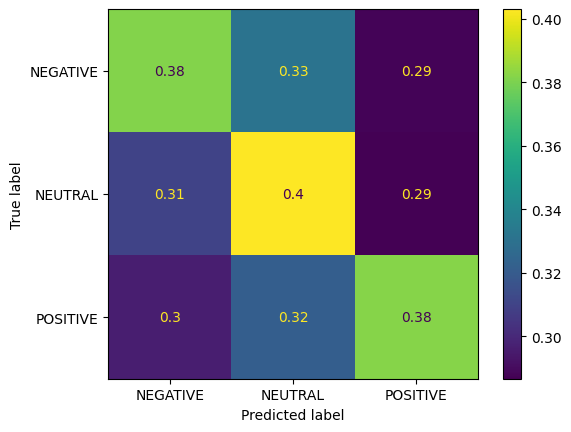

In [7]:
# here is the result of the logistic regression without any preprocessing

# convert the text to numbers using CountVectorizer
vectorizer = CountVectorizer()
Xtrain_without_Preprocessing = vectorizer.fit_transform(Xtrain['Text'])
Xval_without_Preprocessing = vectorizer.transform(Xval['Text'])

# train the logistic regression classifier
list_f1=[]
list_f1_train=[]
list_sample_size=[]

# split the training set in parts that each time are 10% bigger
for times in range(10):
    Xend, X_unused, y, y_unused = train_test_split(Xtrain_without_Preprocessing, Ytrain, test_size=1 - (times * 0.1 + 0.001))

    # train the model  
    classifier = LogisticRegression(max_iter=2000)
    classifier.fit(Xend, np.ravel(y))

    # predict the training set
    results_train = classifier.predict(Xend)

    # predict the validation set
    results = classifier.predict(Xval_without_Preprocessing)

    # calculate the f1 score for both sets
    f1_train = f1_score(y, results_train,average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Yval, results,average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

# plot the results
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

pred=classifier.predict_proba(Xval_without_Preprocessing)
# plot Roc curve
Roc_curve_plot(pred,Ytrain, Yval)

# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(Yval, results,normalize="true")

In [8]:
# Data Preprocessing

!python -m spacy download el_core_news_sm
nlp = spacy.load("el_core_news_sm")

# remove accents
def remove_accent(text):
    d= {ord('\N{COMBINING ACUTE ACCENT}'):None}
    X_without_accents=ud.normalize('NFD',text).translate(d)
    return X_without_accents

def process_tweet(tweet):
    doc = nlp(tweet)
    tweet = ""
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_url and len(token)>1 and len(token)<15 and not token.pos_ == 'VERB':
            tweet += token.lemma_ + " "
    
    return tweet
           
#remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string) 

# remove emojis
Xtrain['Text'] = Xtrain['Text'].map(remove_emoji)
Xval['Text'] = Xval['Text'].map(remove_emoji)
Xmerged['Text'] = Xmerged['Text'].map(remove_emoji)
Xtest['Text'] = Xtest['Text'].map(remove_emoji)

# remove stop words, punctuation, spaces, urls and lemmatize
Xtrain['Text'] = Xtrain['Text'].map(process_tweet)
Xval['Text'] = Xval['Text'].map(process_tweet)
Xmerged['Text'] = Xmerged['Text'].map(process_tweet)
Xtest['Text'] = Xtest['Text'].map(process_tweet)

# remove mentions
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xmerged['Text'] = Xmerged['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'@\S+', '', x))

# remove accents
Xtrain['Text'] = Xtrain['Text'].map(remove_accent)
Xval['Text'] = Xval['Text'].map(remove_accent)
Xmerged['Text'] = Xmerged['Text'].map(remove_accent)
Xtest['Text'] = Xtest['Text'].map(remove_accent)

# remove numbers
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xmerged['Text'] = Xmerged['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'\d+', '', x))

# remove & symbols
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'%', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'%', '', x))
Xmerged['Text'] = Xmerged['Text'].map(lambda x: re.sub(r'%', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'%', '', x))

# remove dots and commas
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xmerged['Text'] = Xmerged['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'[.,]', '', x))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 56.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


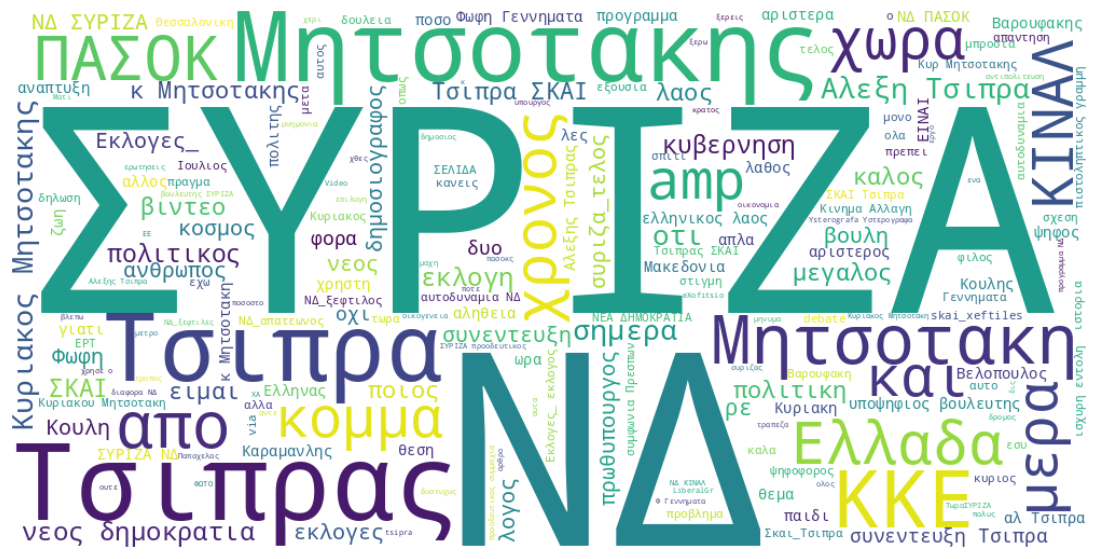

In [9]:
# Concatenate the text data from the column 'Text'
column_data = ' '.join(Xtrain['Text'].dropna())

# Create a wordcloud object before cleaning 
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(column_data)

# Plot the wordcloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

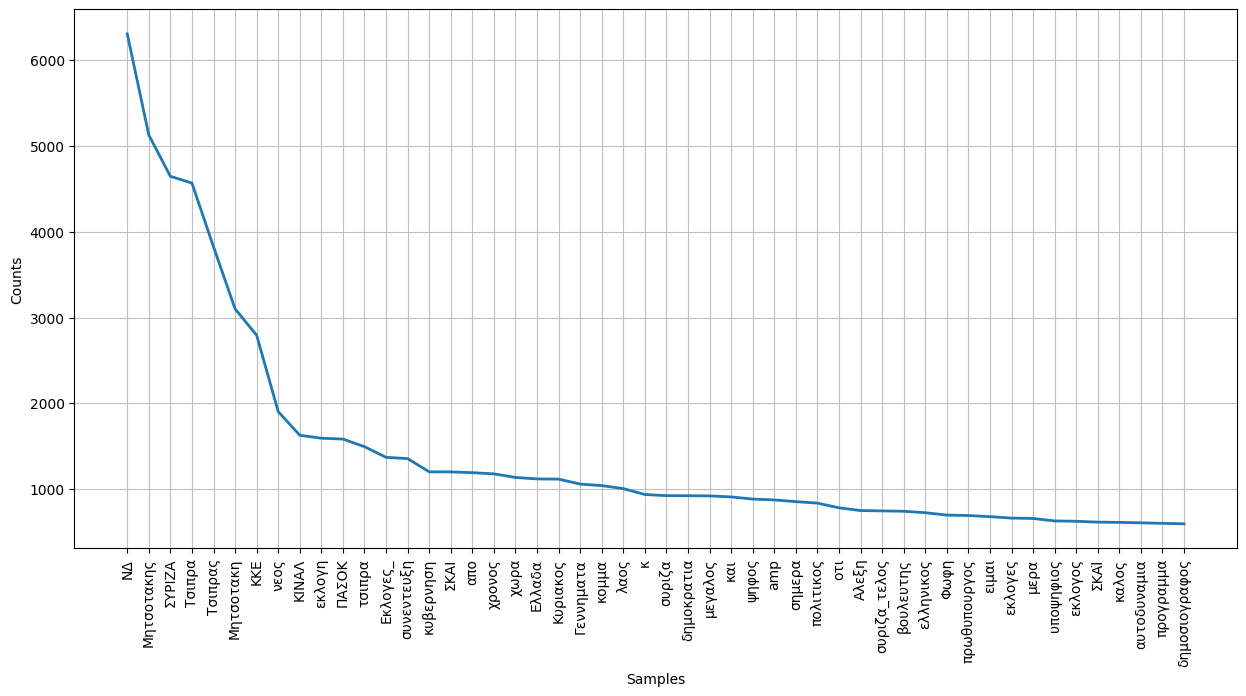

In [10]:
# Create token frequency diagram before cleaning
tokens = [word_tokenize(word, language='greek') for word in Xtrain['Text']]
token_frequency = FreqDist(np.hstack(tokens))
plt.figure(figsize=(15,7))
token_frequency.plot(50, cumulative=False)

In [11]:
# convert text to numbers using TF-IDF
vectorizer_Tfid = TfidfVectorizer()
Xtrain_Tfid = vectorizer_Tfid.fit_transform(Xtrain['Text'])
Xval_Tfid = vectorizer_Tfid.transform(Xval['Text'])

# convert sentiment to numbers
vectorizer = CountVectorizer()
Xtrain= vectorizer.fit_transform(np.ravel(Xtrain['Text']))
Xval= vectorizer.transform(np.ravel(Xval['Text']))
Xmerged= vectorizer.transform(np.ravel(Xmerged['Text']))
Xtest= vectorizer.transform(np.ravel(Xtest['Text']))



F1 Score Train: 1.0
F1 Score Validation: 0.2962452274074044
F1 Score Train: 0.9370081052005291
F1 Score Validation: 0.3603305383291024
F1 Score Train: 0.8965116499897057
F1 Score Validation: 0.37306094777298987
F1 Score Train: 0.8732830750629365
F1 Score Validation: 0.37850028003133535
F1 Score Train: 0.8463619660273017
F1 Score Validation: 0.37910090664051443
F1 Score Train: 0.8259204295741731
F1 Score Validation: 0.3748093740421995
F1 Score Train: 0.8120250176112802
F1 Score Validation: 0.3767751887338692
F1 Score Train: 0.8000053482429099
F1 Score Validation: 0.38786478274793246
F1 Score Train: 0.7879778634425041
F1 Score Validation: 0.3760541532123223
F1 Score Train: 0.7774395844857371
F1 Score Validation: 0.3776103818897956


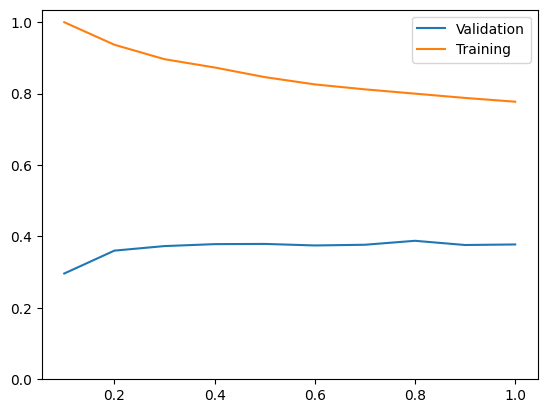

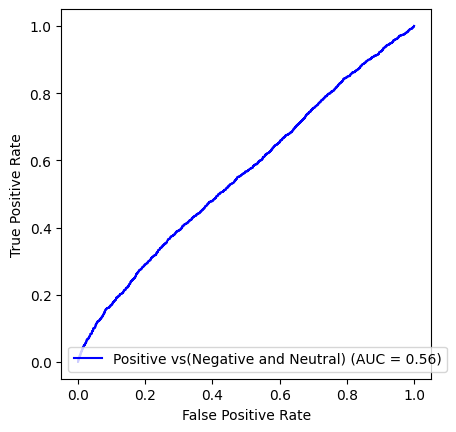

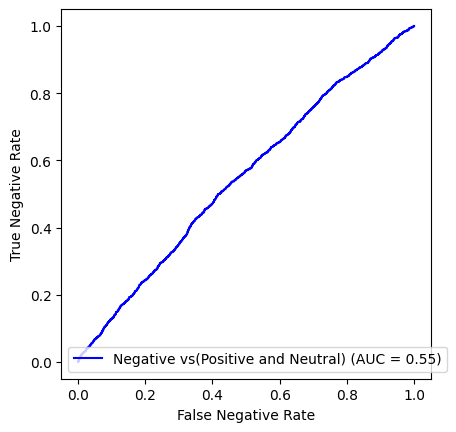

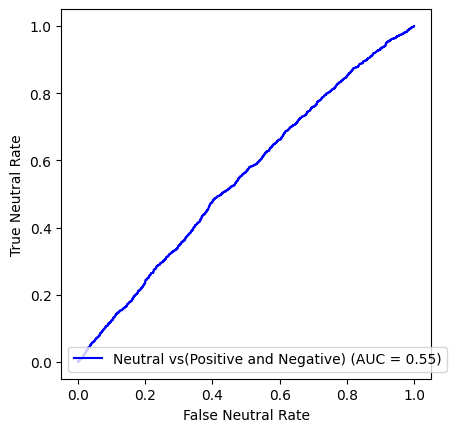

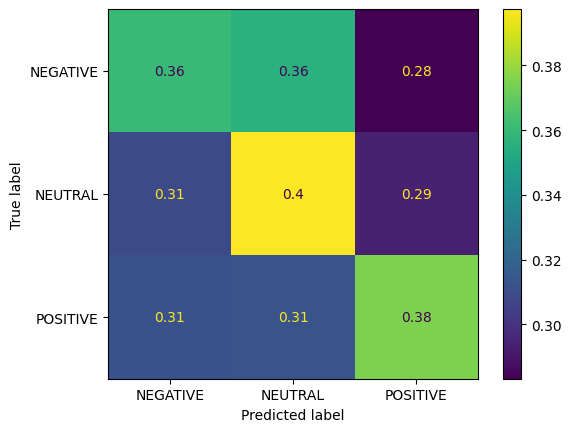

In [12]:
# Train the logistic regression classifier after preprocessing

list_f1=[]
list_f1_train=[]
list_sample_size=[]

# split the training set in parts that each time are 10% bigger
for times in range(10):
    Xend, X_unused, y, y_unused = train_test_split(Xtrain, Ytrain, test_size=1 - (times * 0.1 + 0.001))

    # train the model  
    classifier = LogisticRegression(max_iter=2000)
    classifier.fit(Xend, np.ravel(y))

    # predict the training set
    results_train = classifier.predict(Xend)

    # predict the validation set
    results = classifier.predict(Xval)

    # calculate the f1 score for both sets
    f1_train = f1_score(y, results_train,average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Yval, results,average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

pred=classifier.predict_proba(Xval)
# plot Roc curve
Roc_curve_plot(pred,Ytrain, Yval)

# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(Yval, results,normalize="true")

F1 Score Train: 1.0
F1 Score Validation: 0.33363575988124067
F1 Score Train: 0.895060527505155
F1 Score Validation: 0.378710569192404
F1 Score Train: 0.8375395343196831
F1 Score Validation: 0.3813928519621405
F1 Score Train: 0.8035427168419759
F1 Score Validation: 0.37387374641481613
F1 Score Train: 0.7730109914534907
F1 Score Validation: 0.37870216358815845
F1 Score Train: 0.7514437586273971
F1 Score Validation: 0.3928963429535691
F1 Score Train: 0.7374305845388778
F1 Score Validation: 0.383839418696827
F1 Score Train: 0.7243975582874578
F1 Score Validation: 0.38342057266181306
F1 Score Train: 0.7081771370235632
F1 Score Validation: 0.3870398195169494
F1 Score Train: 0.7026681154277572
F1 Score Validation: 0.3818533503328476


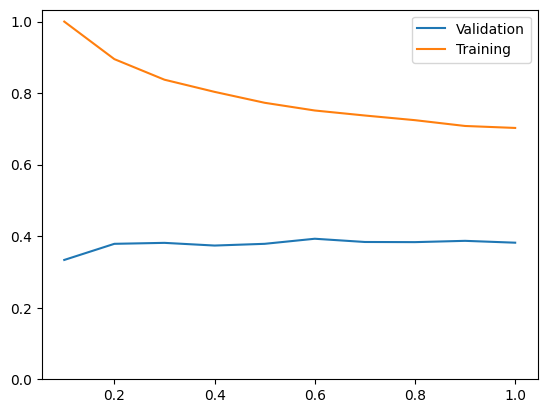

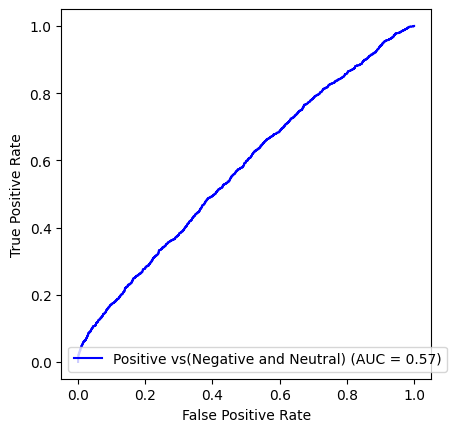

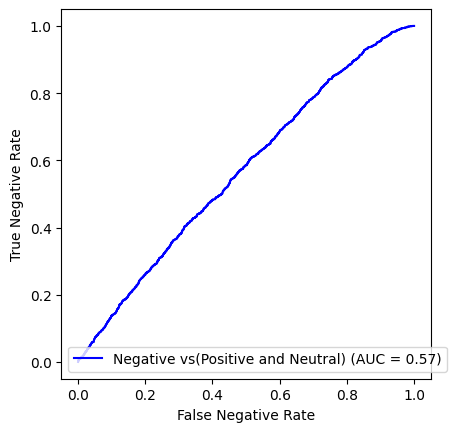

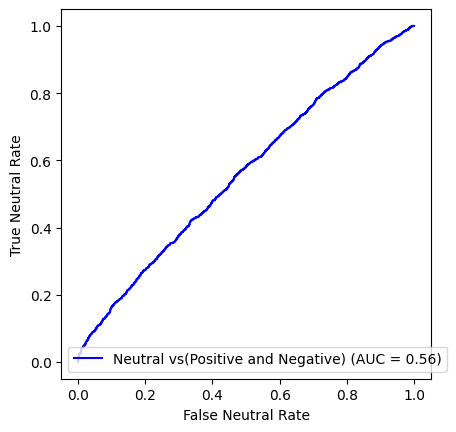

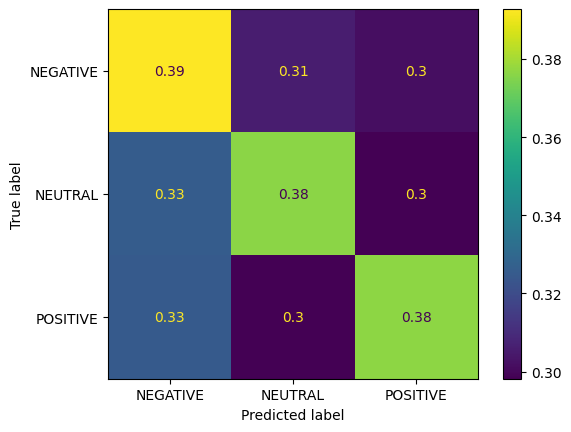

In [13]:
# Train the logistic regression classifier after preprocessing and using TF-IDF

list_f1=[]
list_f1_train=[]
list_sample_size=[]

# split the training set in parts that each time are 10% bigger
for times in range(10):
  Xend, X_unused, y, y_unused = train_test_split(Xtrain_Tfid, Ytrain, test_size=1 - (times * 0.1 + 0.001))

  #train the classifier 
  classifier = LogisticRegression(max_iter=2000)
  classifier.fit(Xend, np.ravel(y))

  #predict in training set
  results_train = classifier.predict(Xend)

  # predict in validation set
  results = classifier.predict(Xval_Tfid)

  #  calculate the F1 score for training and validation set 
  f1_train = f1_score(y, results_train,average="weighted")
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Yval, results,average="weighted")
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# plot the results
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

pred=classifier.predict_proba(Xval_Tfid)
# plot Roc curve
Roc_curve_plot(pred,Ytrain,Yval)

# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(Yval,results,normalize="true")

In [14]:
# Using Optuna to find the best number of components for the TruncatedSVD

def objective (trial):
    # choose the number of components
    components = trial.suggest_int("components", 100, 1000,100) 
    
    # run the TruncatedSVD
    svd = TruncatedSVD(n_components=components, random_state=42)


    Xtrain_help = svd.fit_transform(Xtrain)
    Xval_help= svd.transform(Xval)
        
    # train the classifier
    classifier = LogisticRegression(max_iter=2000)
    classifier.fit(Xtrain_help,np.ravel(Ytrain))
        
    # predict the validation set
    results_valid = classifier.predict(Xval_help)
    
    #calculate the F1 validation score  
    f1val = f1_score(Yval, results_valid, average='weighted')
    
    return f1val

if (optimization):
    # run the study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50) 

F1 Score Train: 0.9722222222222222
F1 Score Validation: 0.3376997281475265
F1 Score Train: 0.5580847774901603
F1 Score Validation: 0.3704682740219312
F1 Score Train: 0.5011620177770623
F1 Score Validation: 0.36827470424868664
F1 Score Train: 0.464366914501124
F1 Score Validation: 0.3927543244795417
F1 Score Train: 0.4514102779379848
F1 Score Validation: 0.38417728082397823
F1 Score Train: 0.4370599630964332
F1 Score Validation: 0.38647237331886397
F1 Score Train: 0.43912004058142434
F1 Score Validation: 0.387003989144047
F1 Score Train: 0.426564720714261
F1 Score Validation: 0.39677776791424163
F1 Score Train: 0.4268187538387853
F1 Score Validation: 0.39501053836341093
F1 Score Train: 0.4241412326231627
F1 Score Validation: 0.3909546392772596


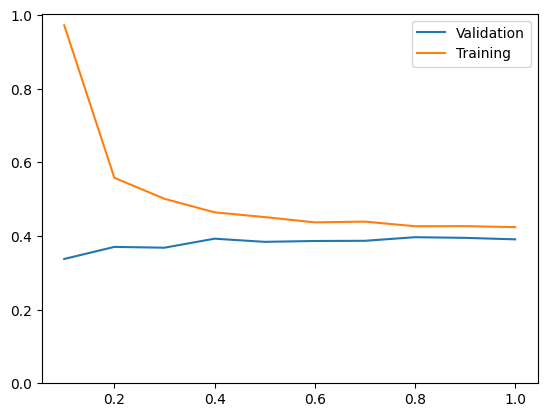

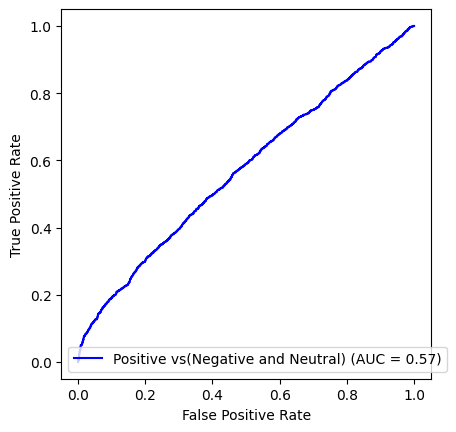

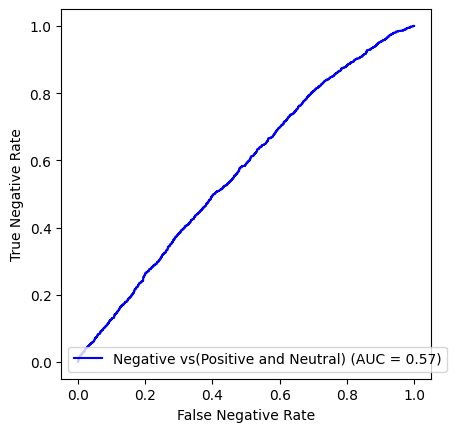

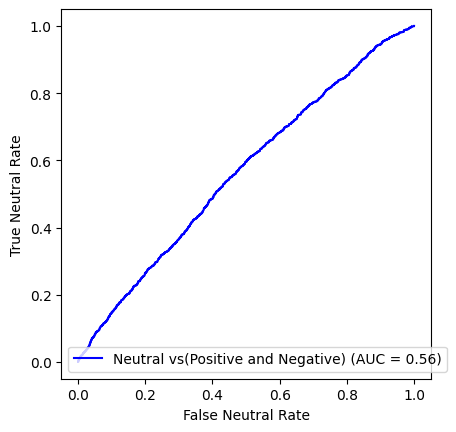

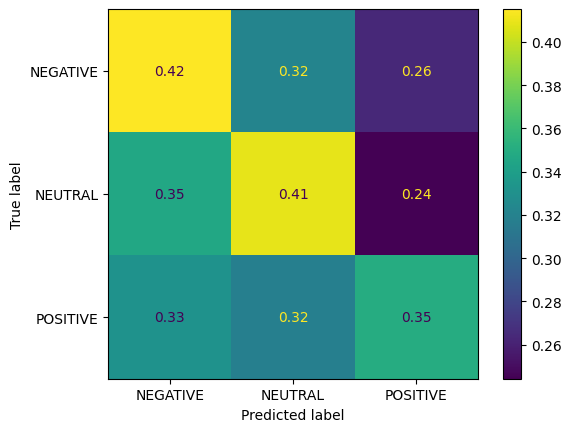

In [15]:
# Train the logistic regression classifier using Dimensionality Reduction

# run the TruncatedSVD
svd = TruncatedSVD(n_components=600, random_state=42)

svd.fit(Xtrain)

X_train_dimensionally_reduction = svd.transform(Xtrain)
X_val_dimensionally_reduction = svd.transform(Xval)
X_test_reduced = svd.transform(Xtest)

list_f1=[]
list_f1_train=[]
list_sample_size=[]

# split the training set in parts that each time are 10% bigger
for times in range(10):
    Xend, X_unused, y, y_unused = train_test_split(X_train_dimensionally_reduction, Ytrain, test_size=1 - (times * 0.1 + 0.001))

    # train the model  
    classifier = LogisticRegression(max_iter=2000)
    classifier.fit(Xend, np.ravel(y))

    # predict the training set
    results_train = classifier.predict(Xend)

    # predict the validation set
    results = classifier.predict(X_val_dimensionally_reduction)

    # calculate the f1 score for both sets
    f1_train = f1_score(y, results_train,average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Yval, results,average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

# plot the results
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

pred=classifier.predict_proba(X_val_dimensionally_reduction)
# plot Roc curve
Roc_curve_plot(pred,Ytrain, Yval)

# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(Yval, results,normalize="true")

F1 Score Train: 0.7696287332349623
F1 Score Validation: 0.38046967883556093
F1 Score Train: 0.7688981526031022
F1 Score Validation: 0.37653099262590883
F1 Score Train: 0.769743071300259
F1 Score Validation: 0.3748904011959998
F1 Score Train: 0.7695800899908926
F1 Score Validation: 0.3732996933762188
F1 Score Train: 0.777972962428711
F1 Score Validation: 0.3778343317788579


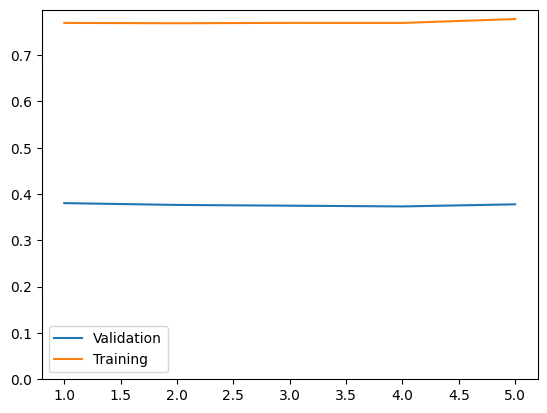

In [16]:
# K fold cross validation

list_f1=[]
list_f1_train=[]
list_sample_size=[]

kf = KFold(n_splits=5)

# split the training and validation set in 5 parts
for trainindex,valindex in kf.split(Xmerged):

  # split the training and validation set
  trainX,valX=Xmerged[trainindex],Xmerged[valindex]
  trainY,valY=np.ravel(Ymerged.iloc[trainindex]),np.ravel(Ymerged.iloc[valindex])

  #train the classifier 
  classifier = LogisticRegression(max_iter=2000)
  classifier.fit(trainX, np.ravel(trainY))

  #predict in training set
  results_train = classifier.predict(trainX)

  # predict in validation set
  results = classifier.predict(valX)

  #  calculate the F1 score for training and validation set 
  f1_train = f1_score(trainY, results_train,average="weighted")
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(valY, results,average="weighted")
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# plot the f1 score for each fold
plt.plot(range(1,len(list_f1)+1), list_f1)
plt.plot(range(1,len(list_f1_train)+1), list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])



In [17]:
# Using Optuna to find the best C for the Logistic Regression

def objective (trial):
    # choose the C
    C = trial.suggest_float("C",0.0001,100)
    
    #train the model
    classifier = LogisticRegression(max_iter=2000,C=C,random_state=100)
    classifier.fit(X_train_dimensionally_reduction,np.ravel(Ytrain))
        
    # predict in validation set  
    results_valid = classifier.predict(X_val_dimensionally_reduction)
    
    # calculate f1 score for validation set  
    f1val = f1_score(Yval, results_valid, average='weighted')
    
    return f1val
    
if (optimization):
    # run the study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

F1 Score Train: 0.9720056313623565
F1 Score Validation: 0.3144113400336344
F1 Score Train: 0.5558913815830362
F1 Score Validation: 0.3660937124827058
F1 Score Train: 0.49008218818844435
F1 Score Validation: 0.37477560057242426
F1 Score Train: 0.4639116080622126
F1 Score Validation: 0.38472914510011264
F1 Score Train: 0.4518853662245254
F1 Score Validation: 0.3798307149852932
F1 Score Train: 0.4411893401595177
F1 Score Validation: 0.38952484857993874
F1 Score Train: 0.43492078286623537
F1 Score Validation: 0.3811499930096502
F1 Score Train: 0.4316479042397513
F1 Score Validation: 0.38686338698446066
F1 Score Train: 0.4247928307205492
F1 Score Validation: 0.39756800672045706
F1 Score Train: 0.4227729158593456
F1 Score Validation: 0.3979873270308827


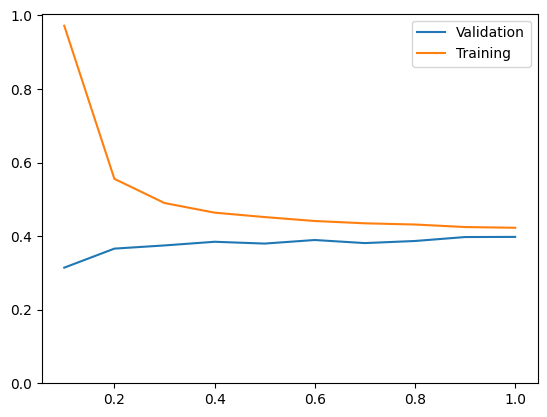

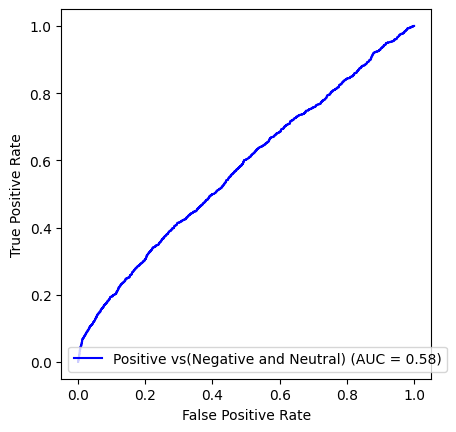

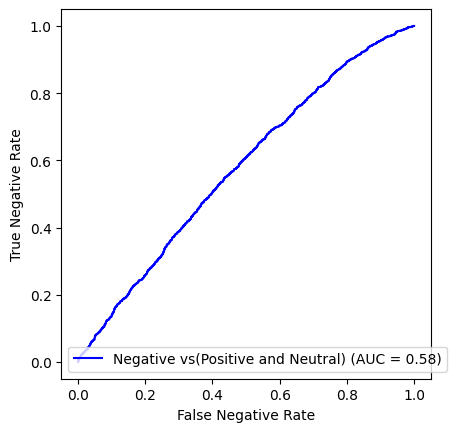

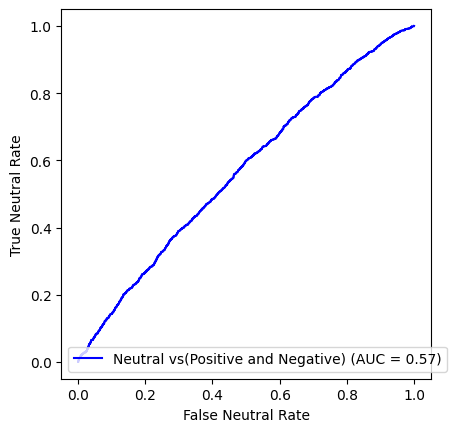

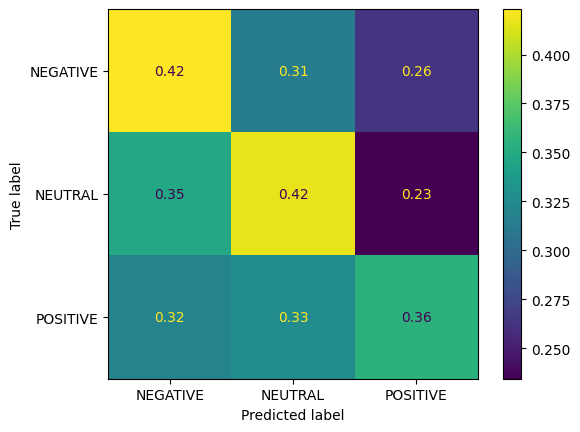

In [18]:
# Train the logistic regression classifier using Dimensional Reduction,the optimal C
# with default solver(lbfgs) and penalty(l2)


list_f1=[]
list_f1_train=[]
list_sample_size=[]

# split the training set in parts that each time are 10% bigger
for times in range(10):
    Xend, X_unused, y, y_unused = train_test_split(X_train_dimensionally_reduction, Ytrain, test_size=1 - (times * 0.1 + 0.001))

    # train the model  
    classifier = LogisticRegression(max_iter=2000,C=0.19)
    classifier.fit(Xend, np.ravel(y))

    # predict the training set
    results_train = classifier.predict(Xend)

    # predict the validation set
    results = classifier.predict(X_val_dimensionally_reduction)

    # calculate the f1 score for both sets
    f1_train = f1_score(y, results_train,average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Yval, results,average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

# plot the results
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

pred=classifier.predict_proba(X_val_dimensionally_reduction)

# plot Roc curve
Roc_curve_plot(pred,Ytrain, Yval)

# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(Yval, results,normalize="true")

# predict the test set 
predictions = classifier.predict(X_test_reduced)

submission_df = pd.DataFrame({"Id": TestSet["New_ID"], "Predicted": predictions})

submission_df.to_csv('submission.csv', index=False)





F1 Score Train: 0.770310633213859
F1 Score Validation: 0.29090003127737707
F1 Score Train: 0.5449788619146951
F1 Score Validation: 0.37607992095586196
F1 Score Train: 0.498683569148418
F1 Score Validation: 0.3768884729378898
F1 Score Train: 0.464683740885611
F1 Score Validation: 0.3751172426526987
F1 Score Train: 0.4472509753771464
F1 Score Validation: 0.39143533739300956
F1 Score Train: 0.43946778391114405
F1 Score Validation: 0.38879164257279897
F1 Score Train: 0.43223602123953336
F1 Score Validation: 0.3877303199910196
F1 Score Train: 0.43166164035517807
F1 Score Validation: 0.38999044236555536
F1 Score Train: 0.42808000125770534
F1 Score Validation: 0.3859809653856199
F1 Score Train: 0.42143837926608274
F1 Score Validation: 0.3932771750110385


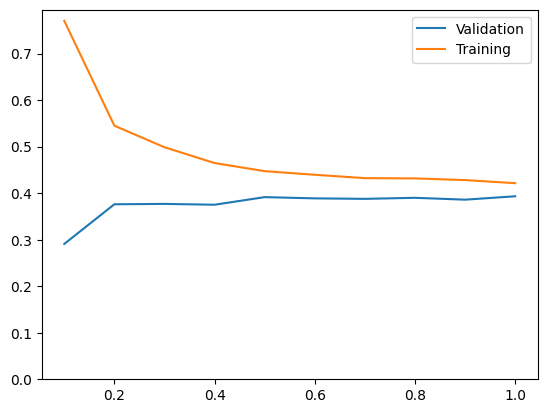

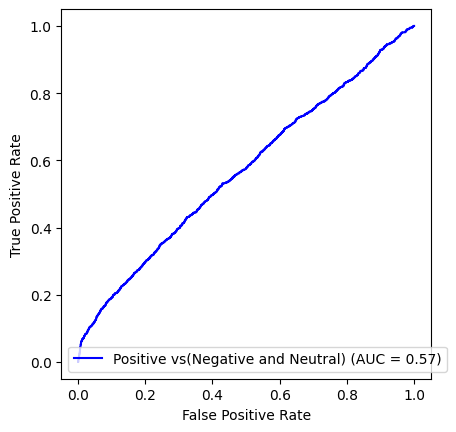

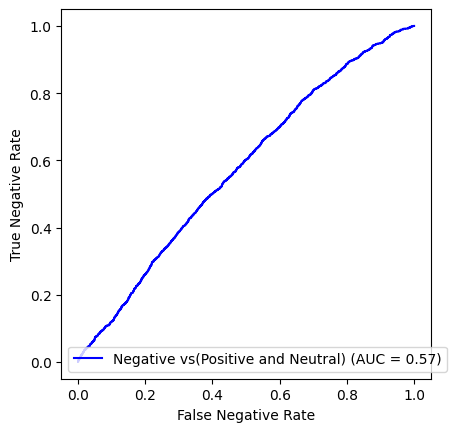

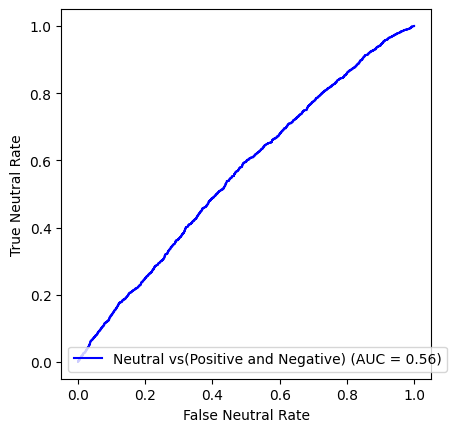

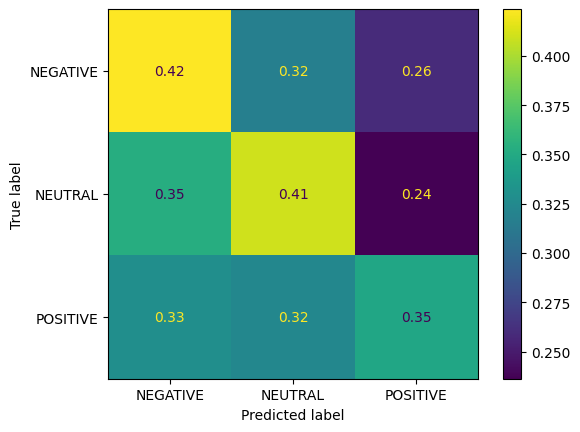

In [19]:
# Train the logistic regression classifier using Dimensional Reduction,l1 penalty and saga solver


list_f1=[]
list_f1_train=[]
list_sample_size=[]

# split the training set in parts that each time are 10% bigger
for times in range(10):
    Xend, X_unused, y, y_unused = train_test_split(X_train_dimensionally_reduction, Ytrain, test_size=1 - (times * 0.1 + 0.001))

    # train the model  
    classifier = LogisticRegression(max_iter=2000,solver='saga',penalty='l1')
    classifier.fit(Xend, np.ravel(y))

    # predict the training set
    results_train = classifier.predict(Xend)

    # predict the validation set
    results = classifier.predict(X_val_dimensionally_reduction)

    # calculate the f1 score for both sets
    f1_train = f1_score(y, results_train,average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Yval, results,average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

# plot the results
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])


pred=classifier.predict_proba(X_val_dimensionally_reduction)

# plot Roc curve
Roc_curve_plot(pred,Ytrain, Yval)

# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(Yval, results,normalize="true")